In [1]:
import numpy as np
import matplotlib.pyplot as plt
import resfuncRead as rfr
import pandas as pd
from scipy.stats import norm
import matplotlib.mlab as mlab
from scipy.optimize import curve_fit

In [2]:
#read the files (from anthony)
#ptres = rfr.getRFunc('data/jardin_ptres.txt')
#qres = rfr.getRFunc('data/jardin_qsummaxres.txt')

In [3]:
#define constants and empty arrays. 
k = 0.157 # from lindhard
q = 1.602*10**-19 #electron charge 
V = 4.0 # voltage Bias
eps = 0.0033 #keV
p_alpha = 0.155393
p_beta = 9.60343*10**(-11)
p_gamma = 0.000506287

q_alpha = 0.166004
q_beta = 0.00233716
q_gamma = 9.52576*10**(-5)

ER = []
ER1 = []
Yield = []
PtNr = []
QR = []
sigQ = []
sigP = []
sigQ1 = []
sigP1 = []
Err=[]
U1 = []
U2 = []
N_eh = []
QNR=[]
PT1 = []

In [4]:
#For Nuclear Recoils 
F =100
N = 100
#Er = np.random.exponential(40,np.uint32(N*0.3)) #tip from anthony 
#Er = np.random.uniform(0,200,N)
#Enr = np.random.choice(np.arange(10,100))

Enr = 100
    
#Err.append(Enr)

esp = 11.5*Enr*(23)**-(7/3)
g = 3*esp**(0.15)+0.7*esp**(0.6)+esp
Y = k*g/(1+k*g)
    
Ptnr = (Y*Enr*V)/(eps*1000) + Enr #central value of Pt
Qnr = Y*Enr
    
for i in np.arange(0,N):
    
    Neh = Y*Enr/eps
    N_eh.append(Neh)
  
    
    #For EP
                
    sig_p1 = np.sqrt(p_alpha + p_beta*Ptnr + p_gamma*(Ptnr**2)) #No Fano 
    sig_p = np.sqrt(p_alpha + p_beta*Ptnr + p_gamma*(Ptnr**2) + (V/1000)**2*Neh*F) # With Fano 
  
    Fnr = np.random.normal(0.0,sig_p)
    Ptnr1 = Ptnr + Fnr #not central value! just.. smeared 
    PT1.append(Ptnr1)
    sigP1.append(sig_p1)
    sigP.append(sig_p)
    
    
    #For EQ
    sig_q1 = np.sqrt(q_alpha + q_beta*Qnr + q_gamma*(Qnr**2) ) #No Fano 
    sig_q = np.sqrt(q_alpha + q_beta*Qnr + q_gamma*(Qnr**2) + eps**2*Neh*F) #With Fano 
    
    Fq = np.random.normal(0.0,sig_q)  
    Qnr1 = Qnr + Fq 
    QNR.append(Qnr1)
    sigQ1.append(sig_q1) #No Fano 
    sigQ.append(sig_q) #With Fano 
    
    
    # Deriviatives to find sigy 
    U_1 = Ptnr/(Ptnr-Qnr1*(V/(eps*1000)))**2  #derivative with respect to Qnr1
    U_2 = -Qnr1/(Ptnr1 -(Qnr1*V/(eps*1000)))**2 #derivative with respect to Ptnf
    U1.append(U_1)
    U2.append(U_2)
    
    #Measured Phonon Energy 
    Ernr = Ptnr1 - (V/(eps*1000))*Qnr1
    ER.append(Ernr)
    ER1.append(Enr)

    yield1 = Qnr1 / Enr #for 1 perfectly known Er. 
    #yield1 = Qnr1 / ER
    Yield.append(yield1)

   

In [5]:
#For Electron Recoils. 

Yield_er = []
ERer = []

#x = np.arange(0,2000,0.1)
#E1er = 82*np.exp(-x/304) #For ER from Kennedy Thesis
E1er = np.random.uniform(0,200,N) #from anthony, Er's are close enough to randomly distributed. 



for i in np.arange(N):
    
    Eer = np.random.choice(E1er) #randomly sample from Energy dist 
    
    
    sig_pee = np.sqrt(p_alpha + p_beta*Eer + p_gamma*(Eer**2)) #Phonon uncertainty 
    sig_qee = np.sqrt(q_alpha + q_beta*Eer + q_gamma*(Eer**2)) #Charge uncertainty 

    Fer = np.random.normal(0.0,sig_pee) #Random energy assuming phonon variance 
    Fqe = np.random.normal(0.0,sig_qee) #Random assuming charge variane


    Pter = (1+(V/eps/1000))*Eer 
    Pter = Pter + Fer
    Qer = Eer
    Qer = Qer + Fqe

    Erer = Pter - (V/eps/1000)*Qer
    ERer.append(Erer)
    
    Yield2 = Qer/Erer
    Yield_er.append(Yield2)

In [6]:
# Make band Fits (Thank you Anthony)

# files contain fits from previous data. I believe that they are fits from real data. As seen, the model has a significantly narrower spread the fits 
# from the data 

bpar_er = rfr.getBandFunc('data/erband_R133') #reads in band data/fit for er data
bpar_nr = rfr.getBandFunc('data/nrband_R133') #reads in band data/fit for nr data 

yer_mu = rfr.makeBFunc(bpar_er[1]['mu']) # sets average fit from 1st (2nd) col in data table. 
yer_muv = np.vectorize(yer_mu) #puts mean data for er in 1D array 
yer_sig = rfr.makeBFunc(bpar_er[1]['sig'],True) #sets uncertainty 
yer_sigv = np.vectorize(yer_sig) #puts uncertainty into 1D array

#following does the same but for nuclear recoils. 
ynr_mu = rfr.makeBFunc(bpar_nr[1]['mu'])
ynr_muv = np.vectorize(ynr_mu)
ynr_sig = rfr.makeBFunc(bpar_nr[1]['sig'],True)
ynr_sigv = np.vectorize(ynr_sig)

# try new fit

xn = np.arange(0.1,100,0.1)
m, c = np.polyfit(ER, Yield, 1)
yn = np.polyval([m, c], xn)

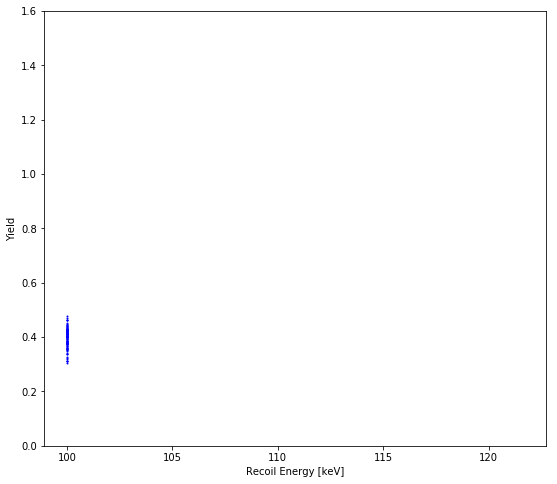

In [7]:
#plot 


fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes


X = np.arange(0.1,100,0.1)

ax1.plot(ER1,Yield,'o',color='b',linewidth=2,markersize=1)
ax1.plot(Qer,Pter,'o',color='k',linewidth=2,markersize=1)
'''
ax1.plot(X,ynr_muv(X),color = 'orange',label='NR mu') #using old data 
#ax1.plot(xn,yn,'r--') #new fit to data (mean)

ax1.plot(X,ynr_muv(X)+3*ynr_sigv(X),'r-',label='NR 3$\sigma$')
ax1.plot(X,ynr_muv(X)-3*ynr_sigv(X),'r-',label=None)

ax1.plot(X,yer_muv(X),color='purple',linestyle='--',label='ER mu')
ax1.plot(X,yer_muv(X)+3*yer_sigv(X),color='purple',linestyle='-',label='ER 3$\sigma$')
ax1.plot(X,yer_muv(X)-3*yer_sigv(X),color='purple',linestyle='-',label=None)
'''
ax1.set_xlabel('Recoil Energy [keV]')
ax1.set_ylabel('Yield')
ax1.set_ylim(0,1.6)
#ax1.set_xlim(0,50)


plt.show()


In [8]:
print(len(ER))
print(len(sigQ1))
print(len(sigP1))
print(len(Yield))
print(len(U1))
print(len(U2))
print(len(N_eh))


100
100
100
100
100
100
100


In [9]:
#removing allowing Yield values from 0->1.6 and removing negative energies. Then creating energy bins. 

data = np.vstack((ER1,Yield,sigQ1,sigP1,U1,U2,N_eh)).T

x = data[data[:,1]>=0, :]

data1 = x[x[:,1]<=1.6,:]
data2 = data1[data1[:,0]>=0,:]
data1 = data2[np.argsort(data2[:, 0])]

#print(data2[:,0:3])
#print("-------------------------------------------------------")
#print(data1[:,0:3])

#a,b,c,d,e,f,g = np.array_split(data1,7)
data = np.array_split(data2,10)

#print(np.argsort(data2[:, 0]))

0.3041698727577973 0.4768689866241915


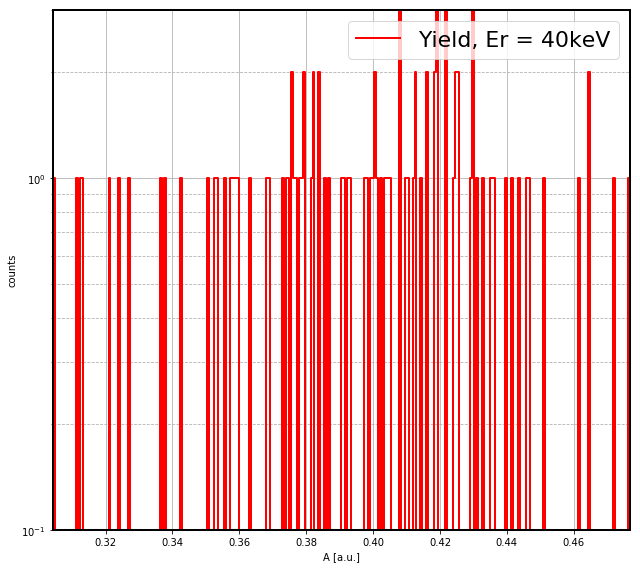

In [10]:
xmin=min(Yield)
xmax=max(Yield)
amax= 30
#print(np.std(val_stat))
print(xmin,xmax)

n_res,n_resx = np.histogram(Yield,300,range=(xmin,xmax))


xresc = (n_resx[:-1] + n_resx[1:]) / 2

#set up a 1d plot
fig,axes = plt.subplots(1,1,figsize=(9.0,8.0),sharex=True)
ax1 = axes

X = np.arange(-amax,amax,0.01)

step, = ax1.step(xresc,n_res, where='mid',color='r', linestyle='-', label='Yield, Er = 40keV', linewidth=2)



ymin=0.1
ymax=max(n_res)


ax1.set_yscale('log')
ax1.set_xlim(xmin, xmax) #in pairs
ax1.set_ylim(ymin,ymax)
ax1.set_xlabel('A [a.u.]')
ax1.set_ylabel('counts')
ax1.grid(True)
ax1.yaxis.grid(True,which='minor',linestyle='--')
ax1.legend(loc=1,prop={'size':22})

for axis in ['top','bottom','left','right']:
  ax1.spines[axis].set_linewidth(2)

plt.tight_layout()
#plt.savefig('figures/figures')
plt.show()

In [11]:
#Finds the width in a yield dist for a particular energy bin to be used later in yield variance calculation (fano)
def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def find_sigma(data):
    mu,sigma = norm.fit(data[:,1])
    n,bins = np.histogram(data[:,1],60)
    
    a = max(data[:,1])
    b = np.average(data[:,1])
    c = sigma
    
    popt,pcov = curve_fit(gaus,bins[:-1],n,p0=[a,b,c])
    
    return  pcov, popt

In [12]:
'''
sig = []
for this_data in data:
    x,y = find_sigma(this_data)
    #print(x,y)
    sig.append(y[2])
    
print(sig)
'''

'\nsig = []\nfor this_data in data:\n    x,y = find_sigma(this_data)\n    #print(x,y)\n    sig.append(y[2])\n    \nprint(sig)\n'

In [13]:
#finds average fano in particular energy bin
def gaus1(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def find_fano(data):
    
    #mu,sigma = norm.fit(data)
    n,bins = np.histogram(data,60)
    
    a = max(data)
    b = np.mean(data)
    c = np.std(data)
    
    popt1,pcov1 = curve_fit(gaus1,bins[:-1],n,p0=[a,b,c])
    '''
    plt.figure()
    plt.hist(data,bins =60)
    plt.plot(bins,gaus1(bins,*popt1), 'r--', linewidth = 2)
    plt.xlabel("Extracted Fano")
    plt.show()
    '''

    
    
    #return  popt1, pcov1, c
    return b,c

In [14]:
#Fano = (b[:,4]**2*b[:,2] +b[:,5]**2*b[:,3] -sigma)**2/(b[:,6]*(b[:,4]**2*eps + V/1000*b[:,5]**2))

def calc_fano(data):
    mean = []
    error = []
    fano = []
    stdy = []
    for x in data:
        #x = data[i]
        U1 = x[:,4]
        U2 = x[:,5]
        sigQ = x[:,2]
        sigP = x[:,3]
        N = x[:,6]
        sigy = np.std(x[:,1],0) #sample std 
        #Fano = (-U1**2*sigQ**2-U2**2*sigP**2 + sigy**2)/(U1**2*eps**2 +U2**2*(V/1000)**2)
        Fano = (sigy**2*Enr**2 - sigQ**2)/(eps**2*N)
        #Fano = Fano/N
        #print(min(x[:,0]),max(x[:,0]))
        
        y,z = find_fano(Fano)
        #print(Fano)
        
        n = len(x[:,1])
        h = np.mean(x[:,1]-np.mean(x[:,1]))
        
        err = np.sqrt((1/n)*((n-3)/(n-1))*sigy**4)*(2*sigy*Enr**2)/(eps**2*N)
        err1 = np.mean(err)
        error.append(err1)
        
        
        fano.append(Fano)
        mean.append(y)
        stdy.append(sigy)
        #error.append(np.std(Fano))
        
        #print(Fano)
       
    return mean, error,fano,stdy
        
        

/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:785: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


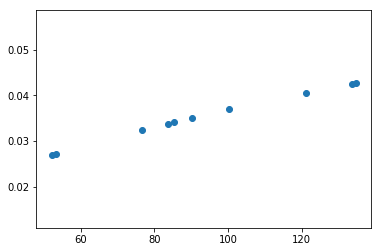

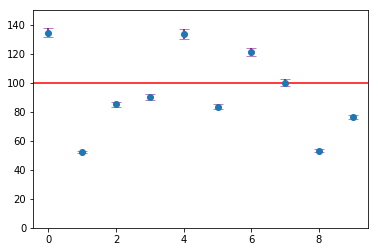

In [15]:
means,errors,fano,sigy= calc_fano(data)
#print(errors)

plt.figure()
plt.scatter(means,sigy)

x = np.arange(0,10)

plt.figure()
plt.errorbar(x,means,yerr=errors,fmt ='o',label = 'error', ecolor = 'purple', Linestyle = 'None', capsize=5, capthick=0.5)
plt.axhline(y=F, color='r', linestyle='-')
plt.ylim(0,150)
plt.show()